<a href="https://colab.research.google.com/github/Anldrnz/Physics-Informed-NN-ODE-PDE-solutions/blob/main/mass_spring_damper_PINN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mass spring damper system:**


In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Visual Related Methods**

In [66]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [67]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

## **Phsyics Function Declarations**

In [68]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem"""
    #mass = 1 - 0.0015*torch.sin(2*math.pi*x) - 0.005*x
    print(d, w0)
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [69]:
# Constants
m = 1 # mass
k = 400 # spring coefficient
b = 4 # damping coefficient
external_force = 0

def f(t, net):
    phy_t = net(t)
    dx  = torch.autograd.grad(phy_t, t, torch.ones_like(phy_t), create_graph=True)[0] # Velocity
    dx2 = torch.autograd.grad(dx,  t, torch.ones_like(dx),  create_graph=True)[0] # Acceleration
    eqn = (m*dx2 + b*dx + k*phy_t + external_force)
    return eqn

## **The Exact Solution**

2.0 20.0
torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


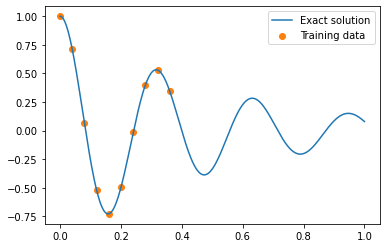

In [70]:
d, w0 = b/(2*m), math.sqrt(k/m)

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## **`Creating the Model`**


In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1,20)
        self.hidden_layer2 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,1)

    def forward(self, t):
        input = t
        layer1_out = torch.tanh(self.hidden_layer1(input))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out) ## For regression, no activation is used in output layer
        return output

In [72]:
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

## **Training and Fitting**

In [ ]:
#epoch = 0
#loss = torch.from_numpy(np.array([1]))
#while loss.data > 0.0005:
    #epoch += 1

files = []
iterations = 15000
for i in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on observed data
    #t_data = Variable(torch.from_numpy(t_sample).float(), requires_grad=False).to(device)
    net_x_out = net(x_data) # output of u(t)
    mse_u = mse_cost_function(net_x_out, y_data)

    # compute the "physics loss"
    phy_input = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)
    physics = f(phy_input, net)
    all_zeros = np.zeros((len(physics),1))
    mse_f = (1e-4)*torch.mean(physics**2)
    #mse_f = mse_cost_function(physics, pt_all_zeros.reshape(len(pt_all_zeros),1))
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    loss.backward()
    optimizer.step()

    if (i+1) % 150 == 0: 
        
        net_x_out = net(x).detach()
        xp = phy_input.detach()
        
        plot_result(x,y,x_data,y_data,net_x_out,xp)
        
        file = "pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

    with torch.autograd.no_grad():
      if i % 500 == 0:
        print(i,"Traning Loss:",loss.data,"mse_u:",mse_u,"mse_f",mse_f)

save_gif_PIL("pinn.gif", files, fps=20, loop=0)

## **Observing the Final Result and Comparing**

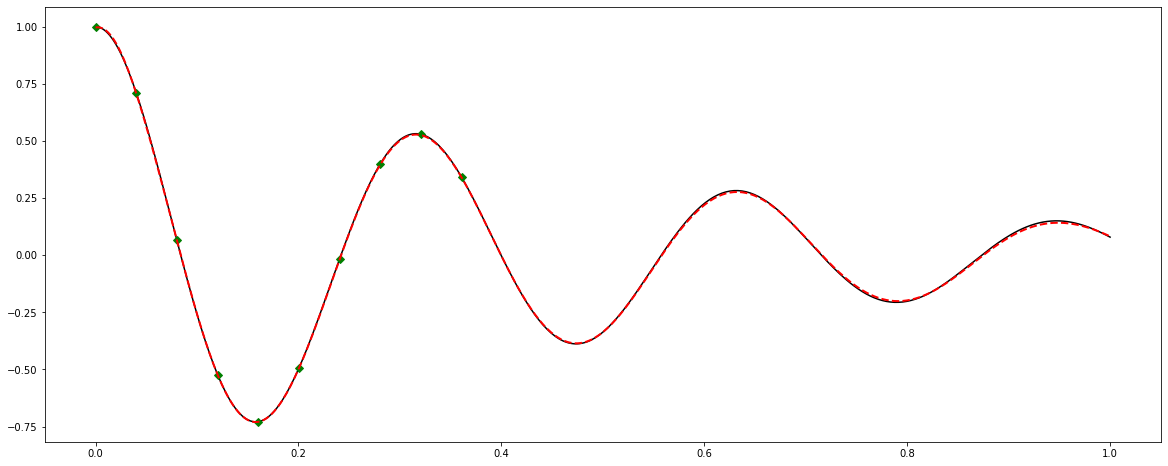

In [76]:
# plot lines
plt.figure(figsize=(20, 8))
plt.plot(x, y, label = "Exact Solution", color="black")

# Training data
plt.plot(x_data, y_data, 'D', color="green")

plt.plot(x, net(x).detach(), "r--", label = "NN Solution", linewidth = 2)

In [ ]:
# Save Model
torch.save(net.state_dict(), "mass_spr_model.pt")

## ***Diminishing Mass Case***

In [87]:
# Constants
m = 1 # mass
k = 400 # spring coefficient
b = 4 # damping coefficient
external_force = 0

def oscillator_m(x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem"""
    m = 1 - 0.15*torch.sin(2*math.pi*x) - 0.005*x
    d, w0 = b/(2*m), torch.sqrt(k/m)
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [78]:
def f(t, net):
    phy_t = net(t)
    dx  = torch.autograd.grad(phy_t, t, torch.ones_like(phy_t), create_graph=True)[0] # Velocity
    dx2 = torch.autograd.grad(dx,  t, torch.ones_like(dx),  create_graph=True)[0] # Acceleration
    eqn = (m*dx2 + b*dx + k*phy_t + external_force)
    return eqn

2.0 20.0
torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


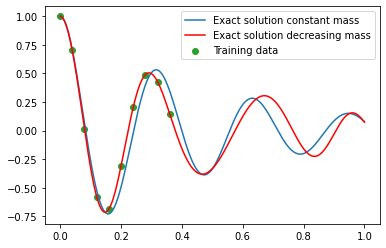

In [92]:
# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(b/(2*m), math.sqrt(k/m), x).view(-1,1)
y_m = oscillator_m(x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y_m[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution constant mass")
plt.plot(x, y_m, label="Exact solution decreasing mass", color='red')
plt.scatter(x_data, y_data, color="tab:green", label="Training data")
plt.legend()
plt.show()